## Coding Assignment 3
**Tianyi Wan; Guoli Rao; Shengbo Lang**

In [142]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize, fsolve
from scipy.stats import norm

import warnings
warnings.filterwarnings('ignore')

## Q1

### X(t) motion:

In [2]:
# params setting
a = 0.025
b = 0.002
sigma_r = 0.02
c = 0.4
k2 = 0.05
rho_inf = 0.4

# model volatility quantities and correlation
sigma_1 = c*sigma_r
v = np.sqrt(c**(-2)-1-2*(rho_inf/c-1))
sigma_2 = sigma_1*v
rho_x = (rho_inf/c-1)/v

In [3]:
# simulate path for x1 and x2
def simulate_x(dt, T):
    time_span = np.linspace(0, T, T*int(1/dt)+1)
    x1 = [0]
    x2 = [0]
    
    def drift_x1(t):
        term1 = ((rho_x*sigma_1*sigma_2/k2/2)**2) * (np.exp(2*k2*t)-2*k2*t-1)
        term2 = (rho_x*sigma_1*sigma_2)/(k2**2) * \
                    (sigma_1*(np.exp(-k2*t)+k2*t-1)+sigma_2*(np.exp(k2*t)+np.exp(-k2*t)-2)/2)
        return (sigma_1*t)**2/2 + term1 + term2
    
    def drift_x2(t):
        term1 = (rho_x*sigma_1*sigma_2/(k2**2)*np.exp(-k2*t)) * \
                    (sigma_1*(np.exp(k2*t)-k2*t-1)+sigma_2*(np.exp(2*k2*t)-2*k2*t-1)/4)
        term2 = (sigma_2**2)/(2*k2*2)*np.exp(-k2*t) * ((rho_x*sigma_1)**2+1) * (np.exp(k2*t)+np.exp(-k2*t)-2)
        return term1 + term2
    
    for i in range(len(time_span)-1):
        dWt_1 = np.random.normal(0, np.sqrt(dt))
        dWt_2 = rho_x*dWt_1 + np.sqrt(1-rho_x**2)*np.random.normal(0, np.sqrt(dt))
        
        x1_diffusion = sigma_1*dWt_1
        x2_diffusion = sigma_2*np.exp(-k2*time_span[i])*dWt_2
        
        x1.append(x1[-1]+drift_x1(time_span[i+1])-drift_x1(time_span[i])+x1_diffusion)
        x2.append(x2[-1]+drift_x2(time_span[i+1])-drift_x2(time_span[i])+x2_diffusion)
        
    return x1, x2

In [4]:
np.random.seed(99)
dt = 1/52
T = 10
num_paths = 10
time_span_motion = np.linspace(0, T, T*int(1/dt)+1)

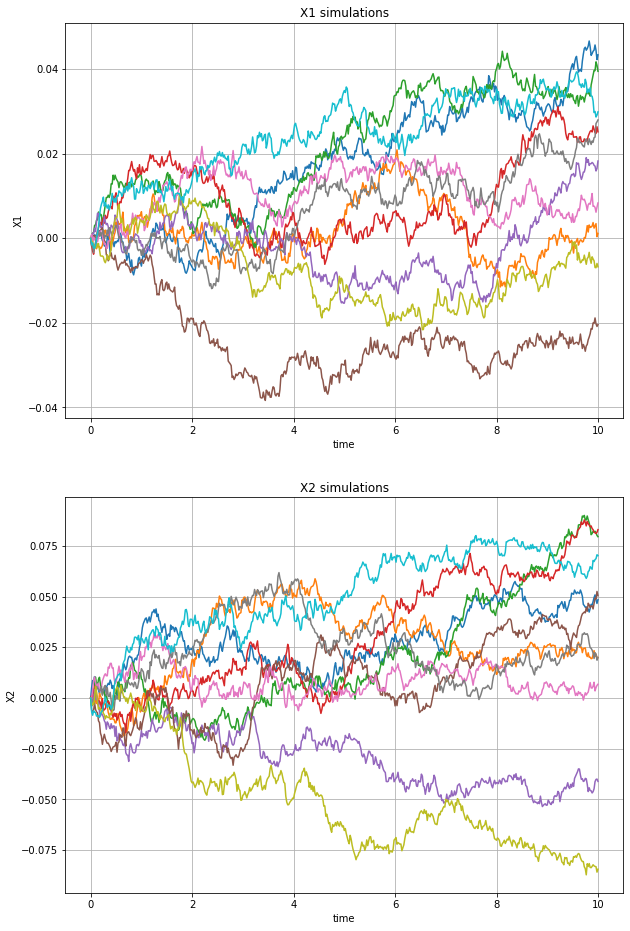

In [5]:
plt.figure(figsize=(10,16))
ax1 = plt.subplot(2,1,1)
ax2 = plt.subplot(2,1,2)
ax1.set(xlabel='time', ylabel='X1', title='X1 simulations')
ax2.set(xlabel='time', ylabel='X2', title='X2 simulations')
ax1.grid()
ax2.grid()

x1s = []
x2s = []

for i in range(num_paths):
    x1, x2 = simulate_x(dt, T)
    x1s.append(x1)
    x2s.append(x2)
    ax1.plot(time_span_motion, x1)
    ax2.plot(time_span_motion, x2)

### Build EE:

In [6]:
def y(t):
    first_layer = [t*sigma_1**2+(rho_x*sigma_1*sigma_2)**2*(np.exp(2*k2*t)-1)/(2*k2),
                  ((rho_x*sigma_1*sigma_2)/k2*(sigma_1*(np.exp(k2*t)-1)+sigma_2*(np.exp(2*k2*t)-1)/2))*np.exp(-k2*t)]
    second_layer = [first_layer[1],
                   (sigma_2**2*(np.exp(2*k2*t)-1)*((rho_x*sigma_1)**2+1)/(2*k2))*np.exp(-k2*2*t)]
    return np.array([first_layer, second_layer])

def G(t, T):
    first_layer = [T-t]
    second_layer = [-(np.exp(-k2*(T-t))-1)/k2]
    return np.array([first_layer, second_layer])

def A(t, T):
    return (-1/2)*((G(t,T).T) @ y(t) @ G(t,T))

def discount_factor(t, T):
    return np.exp(-a*(T-t) - (1/2)*b*(T-t)**2)

def F(t, T, x, dt):
    '''
    since we have done weekly spacing in Q3, and our swap makes payments semi-annually, so we need to transform
    yearly t to weekly
    '''
    discount = discount_factor(0, T)/discount_factor(0, t)
    return discount * np.exp(A(t, T)-G(t, T).T @ (x[:, int(t/dt)]))

def receiver_swap(h, x, dt, dt_4):
    '''
    params:
       h: coupon rate
       x: simulated 2-d paths
       dt: time spacing for simulation
       dt_4: time spacing for payment
    '''
    result = []
    
    time_span_motion = np.linspace(0, T, T*int(1/dt)+1)
    time_span_payment = np.linspace(0, T, T*int(1/dt_4)+1)
    for i in range(len(time_span_motion)):
        value = 0
        # as discussed in the lec, T1 should be interpreted be the first remaining payment date after tj;
        # and T0 should be interpreted as the most recent swap payment date in the past.
        # so we consider 2 cases when current time is on a payment date or somewhere in between.
        if time_span_motion[i] in time_span_payment: 
            start = time_span_motion[i]
        else:
            # most recent
            start = np.floor(time_span_motion[i] + dt_4)
        
        time_span_temp = np.arange(start, 10.00001, dt_4)
        for T_temp in time_span_temp:
            value += ((1+dt_4*h)*F(time_span_motion[i], T_temp, x, dt) - \
                      F(time_span_motion[i], T_temp-dt_4, x, dt))[0][0]

        result.append(value*notional)
    return result 

In [78]:
# as done in CD2

# 48 buckets per year
dt_bucket = 1/48
dt_semi = 1/2
notional = 5e7
T = 10
h_list = [.02, .04, .06, .08]

# num_simulation = 30000
num_simulation = 1000

In [97]:
time_span_bucket = np.linspace(0, T, int(T/(dt_bucket))+1)

# simulate paths
x1s = []
x2s = []
for i in range(num_simulation):
    x1, x2 = simulate_x(dt_bucket, T)
    x1s.append(x1)
    x2s.append(x2)

# store the swaps values in two dimension: (h, (path, time))
receiver_swap_values_h = []
payer_swap_values_h = []
EE_payer_h = []
EE_receiver_h = []

for h in h_list:
    receiver_swap_values = []
    payer_swap_values = []

    for i in range(num_simulation):
        receiver_swap_value = receiver_swap(h, np.array([x1s[i], x2s[i]]), dt_bucket, dt_semi)
        
        receiver_swap_values.append(receiver_swap_value)
        payer_swap_values.append([-v for v in receiver_swap_value])
        
    receiver_swap_values_h.append(receiver_swap_values)
    payer_swap_values_h.append(payer_swap_values)  
    
    EE_receiver_h.append(np.mean(np.clip(np.array(receiver_swap_values), a_min = 0, a_max = None), axis=0))
    EE_payer_h.append(np.mean(np.clip(np.array(payer_swap_values), a_min = 0, a_max = None), axis=0))

#### Receiver EE:

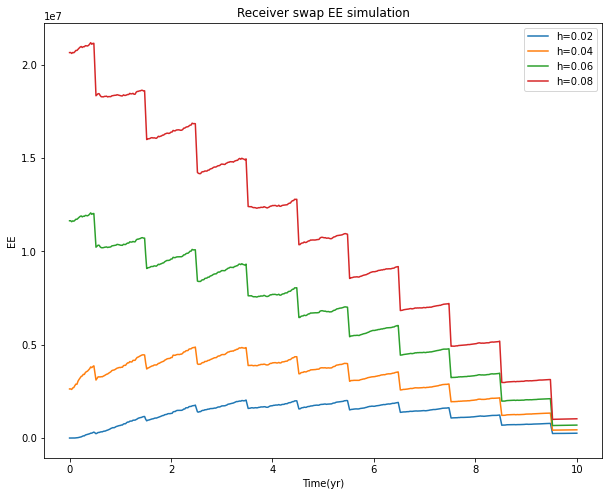

In [101]:
plt.figure(figsize=(10,8))
for i in range(len(EE_receiver_h)):
    plt.plot(time_span_bucket, EE_receiver_h[i], label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('EE')
plt.title('Receiver swap EE simulation')
plt.legend()

#### Payer EE:

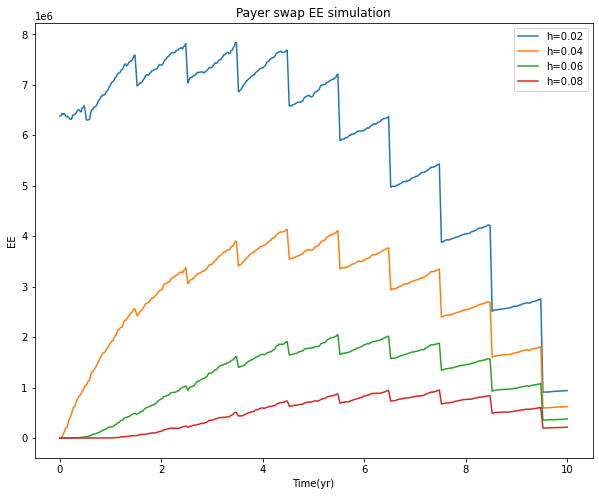

In [102]:
plt.figure(figsize=(10,8))
for i in range(len(EE_payer_h)):
    plt.plot(time_span_bucket, EE_payer_h[i], label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('EE')
plt.title('Payer swap EE simulation')
plt.legend()

## Q2

In [103]:
discounting_factor = np.array([discount_factor(0, t) for t in time_span_bucket])

#### Receiver PVEE:

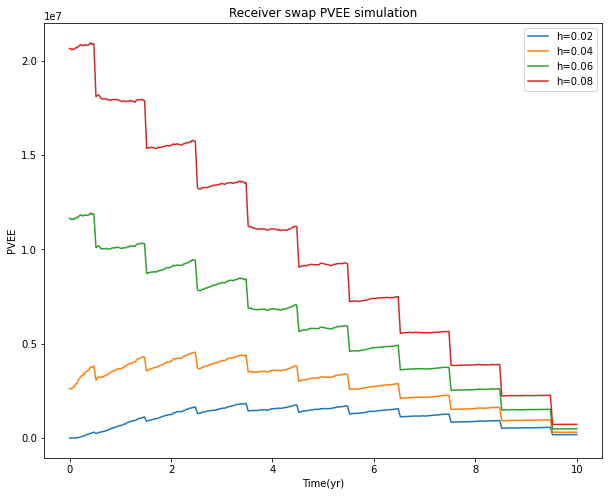

In [104]:
plt.figure(figsize=(10,8))
for i in range(len(EE_receiver_h)):
    plt.plot(time_span_bucket, EE_receiver_h[i]*discounting_factor, label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('PVEE')
plt.title('Receiver swap PVEE simulation')
plt.legend()

#### Payer PVEE:

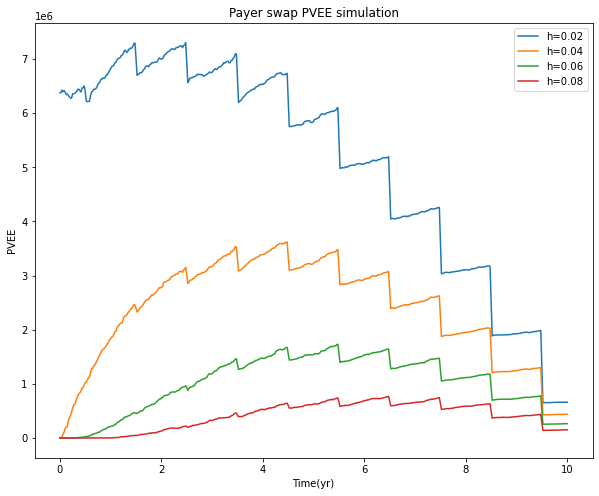

In [105]:
plt.figure(figsize=(10,8))
for i in range(len(EE_payer_h)):
    plt.plot(time_span_bucket, EE_payer_h[i]*discounting_factor, label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('PVEE')
plt.title('Payer swap PVEE simulation')
plt.legend()

## Q3

As mentioned in the requiremnt, $\delta$ is two weeks on our weekly base. This means the time lag is 2 periods.

In [133]:
EE_payer_collateral = []
EE_receiver_collateral = []

for i in range(len(receiver_swap_values_h)):
    # time-axis diff; simulation-axis mean
    EE_payer_collateral.append(np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                               .values, a_min = 0, a_max = None), axis=0))
    EE_receiver_collateral.append(np.mean(np.clip(pd.DataFrame(receiver_swap_values_h[i]).diff(2, axis=1)\
                                                  .values, a_min = 0, a_max = None), axis=0))

#### EE:

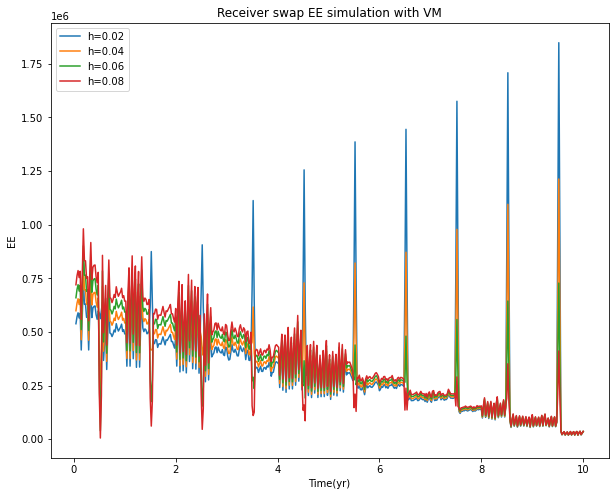

In [134]:
plt.figure(figsize=(10,8))
for i in range(len(EE_receiver_collateral)):
    plt.plot(time_span_bucket, EE_receiver_collateral[i], label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('EE')
plt.title('Receiver swap EE simulation with VM')
plt.legend()

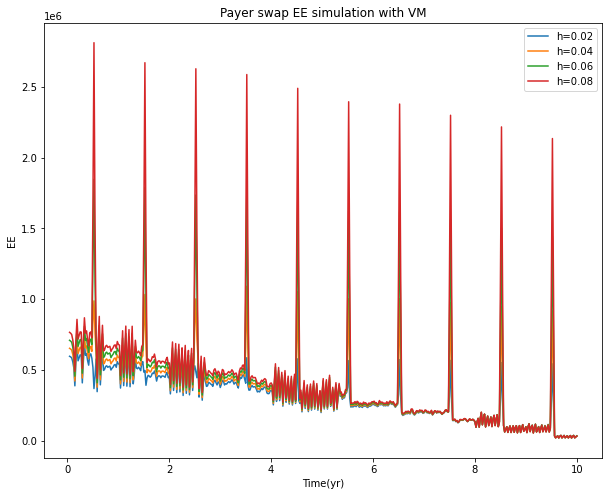

In [135]:
plt.figure(figsize=(10,8))
for i in range(len(EE_payer_collateral)):
    plt.plot(time_span_bucket, EE_payer_collateral[i], label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('EE')
plt.title('Payer swap EE simulation with VM')
plt.legend()

#### PVEE:

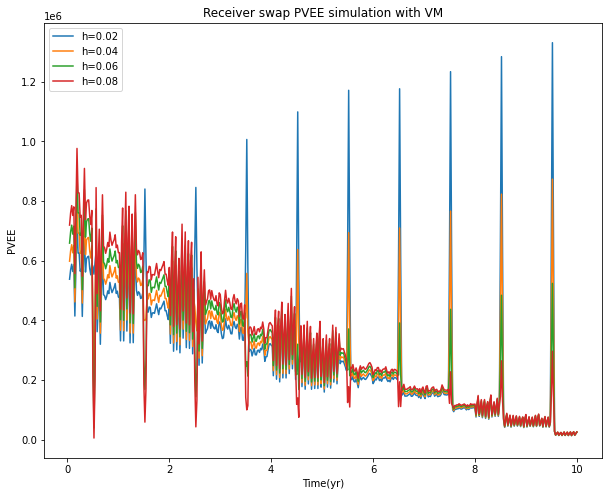

In [136]:
plt.figure(figsize=(10,8))
for i in range(len(EE_receiver_collateral)):
    plt.plot(time_span_bucket, EE_receiver_collateral[i]*discounting_factor, label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('PVEE')
plt.title('Receiver swap PVEE simulation with VM')
plt.legend()

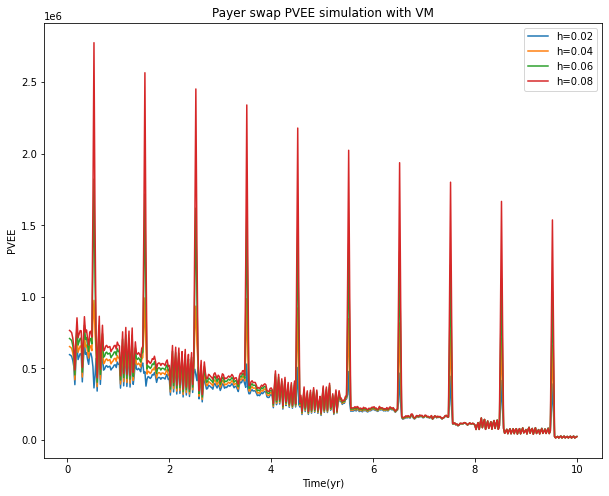

In [137]:
plt.figure(figsize=(10,8))
for i in range(len(EE_payer_collateral)):
    plt.plot(time_span_bucket, EE_payer_collateral[i]*discounting_factor, label=f'h={h_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('PVEE')
plt.title('Payer swap PVEE simulation with VM')
plt.legend()

## Q4
#### Get the h_par rate:

In [138]:
# apply Equation(3) in Lec7
# for receiver swap we just need to flip the sign
time_span_payment = np.linspace(0, T, T*int(1/dt_semi)+1)

def receiver_swap_cd2(h):
    value = 0
    def discount_factor(t, T):
        return np.exp(-a*(T-t) - (1/2)*b*(T-t)**2)
       
    for i in range(len(time_span_payment)-1):
        value += discount_factor(0, time_span_payment[i+1])*(1+h*dt_semi) - \
                    discount_factor(0, time_span_payment[i+1]-dt_semi)    
    return value * notional

In [139]:
h_par = fsolve(receiver_swap_cd2, 0)[0]
h_par

0.03472106682700023

#### Including IM impact:

In [147]:
payer_swap_values_q4 = []

for i in range(num_simulation):
    rvs = receiver_swap(h_par, np.array([x1s[i], x2s[i]]), dt_bucket, dt_semi)
    payer_swap_values_q4.append([-v for v in rvs])

In [157]:
p_list = [0.8, 0.9, 0.99, 0.999]

# omega constant as mentioned in LEC7 to approximately express im
def omega(p):
    return (norm.pdf(norm.ppf(p))-norm.ppf(p)*(1 - p)) * np.sqrt(2*np.pi)

In [158]:
EE_payer_p_q4 = []
for p in p_list:
    payer_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_q4).diff(2, axis=1).values, \
                                 a_min = 0, a_max = None), axis=0)
    EE_payer_p_q4.append(payer_temp * Omega(p))

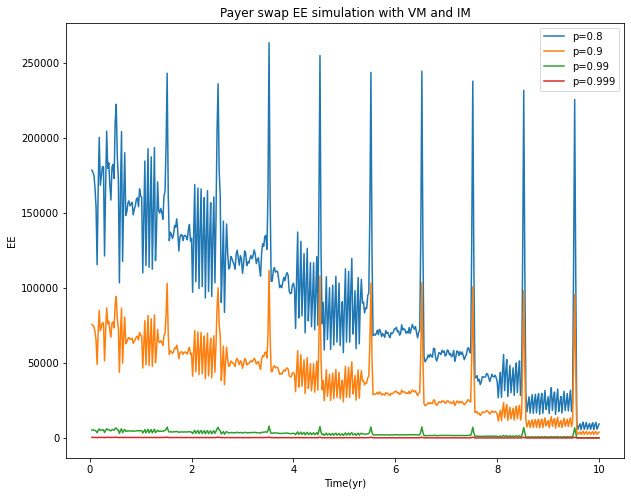

In [159]:
plt.figure(figsize=(10,8))
for i in range(len(EE_payer_p_q4)):
    plt.plot(time_span_bucket, EE_payer_p_q4[i], label=f'p={p_list[i]}')
plt.xlabel('Time(yr)') 
plt.ylabel('EE')
plt.title('Payer swap EE simulation with VM and IM')
plt.legend()

## Q5

In [160]:
lambda_a = 0.045
lambda_b = 0.02

# time 0 survival probability for A and B, denoted XA(0,t) and XB(0,t)
def x_a(t, T):
    return np.exp(-lambda_a * (T-t))

def x_b(t, T):
    return np.exp(-lambda_b * (T-t))

ra = 0.4
rb = 0.4

In [161]:
xa = np.array([x_a(0, t) for t in time_span_bucket])
xb = np.array([x_b(0, t) for t in time_span_bucket])

#### 1. No collateral:

In [162]:
cva_payer_none_q5 = []
cva_receiver_none_q5 = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(payer_swap_values_h[i], a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_payer_none_q5.append(-(1-ra) * np.sum(payer_temp * np.hstack([0, np.diff(xa)])))
    
    receiver_temp = np.mean(np.clip(receiver_swap_values_h[i], a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_receiver_none_q5.append(-(1-ra) * np.sum(receiver_temp * np.hstack([0, np.diff(xa)])))

#### 2. Full Variation Margin:

In [196]:
cva_payer_vm_q5 = []
cva_receiver_vm_q5 = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_payer_vm_q5.append(-(1-ra) * np.nansum(payer_temp * np.hstack([0, np.diff(xa)])))
    
    receiver_temp = np.mean(np.clip(pd.DataFrame(receiver_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_receiver_vm_q5.append(-(1-ra) * np.nansum(receiver_temp * np.hstack([0, np.diff(xa)])))

#### 3. Full Variation Margin and Initial Margin at p = 99%:

In [198]:
cva_payer_vmim_q5 = []
cva_receiver_vmim_q5 = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor*omega(0.99)
    cva_payer_vmim_q5.append(-(1-ra) * np.nansum(payer_temp * np.hstack([0, np.diff(xa)])))
    
    receiver_temp = np.mean(np.clip(pd.DataFrame(receiver_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor*omega(0.99)
    cva_receiver_vmim_q5.append(-(1-ra) * np.nansum(receiver_temp * np.hstack([0, np.diff(xa)])))

#### 4. Result:

In [199]:
result_q5 = pd.DataFrame(np.array([cva_payer_none_q5, cva_payer_vm_q5, cva_payer_vmim_q5,
                                  cva_receiver_none_q5, cva_receiver_vm_q5, cva_receiver_vmim_q5]),
                        index=pd.MultiIndex.from_product([['payer', 'receiver'], ['No collateral', 'VM', 'VMIM']]),
                        columns=h_list)
result_q5.columns.name = 'h'
result_q5

h                               0.02           0.04          0.06  \
payer    No collateral  1.153160e+06  517306.633446  2.137539e+05   
         VM             6.437911e+04   71733.894415  8.041486e+04   
         VMIM           5.468439e+02     609.316282  6.830534e+02   
receiver No collateral  2.360232e+05  633132.836444  1.362543e+06   
         VM             6.826075e+04   69029.299432  7.112404e+04   
         VMIM           5.798149e+02     586.343129  6.041361e+02   

h                               0.08  
payer    No collateral  8.302798e+04  
         VM             9.016493e+04  
         VMIM           7.658717e+02  
receiver No collateral  2.264781e+06  
         VM             7.428788e+04  
         VMIM           6.310102e+02

#### 5. Comments:

## Q6

#### 1. No collateral:

In [205]:
cva_payer_none_q6 = []
cva_receiver_none_q6 = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(payer_swap_values_h[i], a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_payer_none_q6.append(-(1-ra) * np.nansum(payer_temp * xb * np.hstack([0, np.diff(xa)])))
    
    receiver_temp = np.mean(np.clip(receiver_swap_values_h[i], a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_receiver_none_q6.append(-(1-ra) * np.nansum(receiver_temp * xb * np.hstack([0, np.diff(xa)])))

#### 2. Full Variation Margin:

In [206]:
cva_payer_vm_q6 = []
cva_receiver_vm_q6 = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_payer_vm_q6.append(-(1-ra) * np.nansum(payer_temp * xb * np.hstack([0, np.diff(xa)])))
    
    receiver_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor
    cva_receiver_vm_q6.append(-(1-ra) * np.nansum(receiver_temp * xb * np.hstack([0, np.diff(xa)])))

#### 3. Full Variation Margin and Initial Margin at p = 99%:

In [207]:
cva_payer_vmim_q6 = []
cva_receiver_vmim_q6 = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor*omega(0.99)
    cva_payer_vmim_q6.append(-(1-ra) * np.nansum(payer_temp * xb * np.hstack([0, np.diff(xa)])))
    
    receiver_temp = np.mean(np.clip(pd.DataFrame(receiver_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor*omega(0.99)
    cva_receiver_vmim_q6.append(-(1-ra) * np.nansum(receiver_temp * xb * np.hstack([0, np.diff(xa)])))

#### 4. Result:

In [214]:
result_q6 = pd.DataFrame(np.array([cva_payer_none_q6, cva_payer_vm_q6, cva_payer_vmim_q6,
                                  cva_receiver_none_q6, cva_receiver_vm_q6, cva_receiver_vmim_q6]),
                        index=pd.MultiIndex.from_product([['payer', 'receiver'], ['No collateral', 'VM', 'VMIM']]),
                        columns=h_list)
result_q6.columns.name = 'h'
result_q6

h                               0.02           0.04          0.06  \
payer    No collateral  1.071678e+06  473422.688849  1.926678e+05   
         VM             6.049350e+04   67423.242017  7.557264e+04   
         VMIM           5.138390e+02     572.701085  6.419230e+02   
receiver No collateral  2.156105e+05  588953.498677  1.279797e+06   
         VM             6.049350e+04   67423.242017  7.557264e+04   
         VMIM           5.429999e+02     550.707834  5.687756e+02   

h                               0.08  
payer    No collateral  7.388623e+04  
         VM             8.469511e+04  
         VMIM           7.194104e+02  
receiver No collateral  2.132613e+06  
         VM             8.469511e+04  
         VMIM           5.951088e+02

#### 5. Comments:

## Q7

In [209]:
sb = 0.012

In [210]:
fva_payer_q7 = []
fva_receiver_q7 = []

for i in range(len(receiver_swap_values_h)):
    fva_payer_q7.append(np.nansum(np.mean(payer_swap_values_h[i], axis=0) * discounting_factor * xb * sb/52))
    fva_receiver_q7.append(np.nansum(np.mean(receiver_swap_values_h[i], axis=0) * discounting_factor * xb * sb/52))

#### Result:

In [213]:
result_q7 = pd.DataFrame(np.array([fva_payer_q7, fva_receiver_q7]),
                        index=pd.MultiIndex.from_product([['payer', 'receiver'], ['FVA']]),
                        columns=h_list)
result_q7.columns.name = 'h'
result_q7

,h,0.02,0.04,0.06,0.08
payer,FVA,412768.570532,-47997.34071,-508763.251952,-969529.163194
receiver,FVA,-412768.570532,47997.34071,508763.251952,969529.163194


#### Comments:

## Q8

In [215]:
mva_payer_q8 = []
mva_receiver_q8 = []

for i in range(len(receiver_swap_values_h)):
    payer_temp = np.mean(np.clip(pd.DataFrame(payer_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor 
    mva_payer_q8.append(np.sqrt(2*np.pi) * norm.ppf(0.99) * np.nansum(payer_temp * xb * sb/52))
    
    receiver_temp = np.mean(np.clip(pd.DataFrame(receiver_swap_values_h[i]).diff(2, axis=1)\
                                    .values, a_min = 0, a_max = None), axis=0)*discounting_factor 
    mva_receiver_q8.append(np.sqrt(2*np.pi) * norm.ppf(0.99) * np.nansum(receiver_temp * xb * sb/52))

#### Result:

In [216]:
result_q8 = pd.DataFrame(np.array([mva_payer_q8, mva_receiver_q8]),
                        index=pd.MultiIndex.from_product([['payer', 'receiver'], ['MVA']]),
                        columns=h_list)
result_q8.columns.name = 'h'
result_q8

,h,0.02,0.04,0.06,0.08
payer,MVA,166931.226033,185941.896186,208489.294074,233924.857049
receiver,MVA,177794.886503,179111.075209,183963.991651,191705.073179


#### Comments: